In [2]:
# custom jupyter lab theme
import jlmxj

# mnet debug
#### Vertebra segmentation for spinal x-rays.

### dataloading

In [1]:
import os
import numpy as np
# np.set_printoptions(precision=3, suppress=True)
import torch.nn as nn

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from unet_nbinary import unet
import json
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
######################## Hyperparameters #################################
# These are SUGGESTED hyperparameters - please feel free to use what works for you.
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10  # orig 10, 5 for large original image size
validation_batch_size = 5  # orig 10
learning_rate = 0.001
num_classes = 26

# This num_epochs is probably too much, design an early stopping method.
num_epochs = 20

# Data Directory
# TODO: Please fill in the directory of the segmentation data here
# input_data_dir = mask_json = r'HW6_data/segmentation'
input_data_dir = mask_json = r'data'

# Mask Json directory
# TODO: Please fill in the path to the mapping.json here
# mask_json = r'HW6_data/mapping.json'
mask_json = r'data/mapping.json'

# Image Transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
img_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
# We have provided you with some preprocessing code for the images but you should
# design your own dataloader
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, op, mask_json_path, transforms=None):
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 8 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self, idx):
#         print('dataloader going through number',idx)
        idir = os.path.join(self.data_dir, str(idx))  # data/train/0 etc
        
        allfiles = list(os.listdir(idir))
        allfiles.sort()
        
        # get height, width  # MXJ resize
        sample_data = allfiles[0]
#         sample_data = io.imread(os.path.join(idir, sample_data))
        sample_data = Image.open(os.path.join(idir, sample_data))
#         height, width = np.shape(sample_data)  # 1250, 620
        
        # rescale to 1280 x 640 / 2, so 640 x 320
#         sample_data = resize(sample_data, (640, 320), anti_aliasing=True)
        sample_data = sample_data.resize((320, 640))  # PIL flipped for some reason
        sample_data = np.array(sample_data)  # to numpy
        height, width = np.shape(sample_data)  # 640 x 320
        
#         total_vertebra = list(range(0,26))
        
        mask_array = np.zeros((height, width, self.mask_num))
        
        for i in range(len(allfiles)):
            filename = allfiles[i]
            if filename.startswith('image'):
                img_name = filename
            elif filename.startswith('vertebra'):
                vertebra_num = np.uint8(filename.split('_')[1])
                rawpath = os.path.join(idir, filename)
                raw = Image.open(rawpath)
#                 raw = io.imread(rawpath)
#                 raw = resize(raw, (640, 320), anti_aliasing=True)  # MXJ resize
                raw = raw.resize((320,640))
                raw = np.array(raw)
                mask_array[:,:,vertebra_num] = raw
        
#         img_name = str(idx) + '_input.jpg'
#         mask_name = str(idx) + '_mask.png'
#         img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
#         mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
#         h, w = mask.shape

#         img = io.imread(os.path.join(idir, img_name))
        img = Image.open(os.path.join(idir, img_name)).convert('RGB')
#         img = resize(img, (640, 320), anti_aliasing=True)  # MXJ resize
        img = img.resize((320,640))
        img = np.array(img)
        mask = mask_array
        
        img = np.float32(img)
        mask = np.float32(mask)

        # Convert grey-scale label to one-hot encoding
#         new_mask = np.zeros((h, w, self.mask_num))
#         for idx in range(self.mask_num):
#             new_mask[:, :, idx] = mask == self.mask_value[idx]

        # Transform image and mask
        if self.transform:
#             img, mask = self.img_transform(img, new_mask)
            img, mask = self.img_transform(img, mask)

        # Use dictionary to output
        sample = {'img': img, 'mask': mask}

        return sample

    def img_transform(self, img, mask):
        img = self.transform(img)
        mask = self.transform(mask)

        return img, mask

In [4]:
# TODO: Implement DiceLoss, Training, Validation, Earlystopping, Loss Plots etc (whatever the qn asks you)
class dice_loss(nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()
        self.eps = 1e-9

    def forward(self, logits, target):
        # inputs are both shape N x K x H x W (N is batch size, K is # class), 
        N, K, H, W = logits.shape

        # Figure out how many classes there are in the target image for each batch
    #         _, label = torch.max(target, dim=1)
    #         label = label.cpu().numpy()
    #         N_label = np.zeros(N)
    #         for i in range(N):
    #             N_label[i] = np.unique(label[i,:,:]).shape[0]

        l_flat = logits.view(logits.size(0), logits.size(1), -1) # want to be size N x K x HW
        t_flat = target.view(target.size(0), target.size(1), -1) # want to be size N x K x HW
        intersection = torch.sum(torch.mul(l_flat, t_flat), dim=2) # N x K
        num = 2 * intersection # + self.eps

        den = torch.sum(l_flat, dim=2) + torch.sum(t_flat, dim=2) + self.eps # N x K
        dice_score = torch.div(num, den) # N x K

        # First mean over class manually, using N_label
    #         dice_score = torch.sum(dice_score, dim=1) / torch.from_numpy(N_label).to(device)
        # Now mean over batch
        dice_score = torch.mean(dice_score, dim=(0,1)) # scalar now

        loss = 1 +  -1.0*dice_score # per-class loss
        loss.requires_grad_(True)
        return loss


def dice_score(preds, one_hot_target, num_classes=num_classes):
    N, K, H, W = preds.shape
    
    #Not differentiating anything, so detach everything
    target_np = one_hot_target.clone().detach().cpu().numpy()
    preds_torch = preds.clone().detach().cpu()
    
    # one-hot encode preds to calculate denominator
    _, preds_torch = torch.max(preds_torch, dim=1)
    preds_onehot = nn.functional.one_hot(preds_torch, num_classes)
    preds_np = np.transpose(preds_onehot.numpy(), (0, 3, 1, 2)) # N x K x H x W

    num = 2*np.sum(((preds_np == target_np) & (target_np != 0) & (preds_np != 0)), axis=(0, 2, 3)) # sum up per class, so den is size (K,)

    den = np.sum(preds_np, axis=(0, 2, 3)) + np.sum(target_np, axis=(0, 2, 3)) # sum up per class, so den is size (K,)
    den[np.where(den == 0)] = 1e-9
    num[np.where(den == 0)] = 1e-9
    dice_coeff = num / den

    return(dice_coeff)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.zero_()

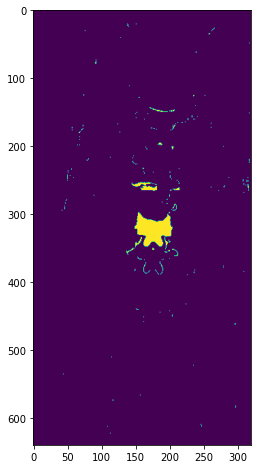

In [10]:
slice19 = output_data[0,19,:,:]
threshed19 = np.zeros((640,320))

for i in range(640):
    for j in range(320):
        if slice19[i,j] > 0.00001:
            threshed19[i,j] = 1
            
plt.figure(figsize=(12,8))
plt.imshow(threshed19)

In [5]:
# Instantiate DataSets
train_dataset = SegmentationDataset(input_data_dir, 'train', mask_json, transforms=train_transform)
val_dataset   = SegmentationDataset(input_data_dir, 'val', mask_json, transforms=img_transform)
test_dataset  = SegmentationDataset(input_data_dir, 'test', mask_json, transforms=img_transform)

In [6]:
# Instantiate dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=validation_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
#
# Define parameters, model, etc
#

model = None
# num_classes = 26

# etc
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initializations
model = unet(num_classes=num_classes, useBN=True)
model = model.to(device)
weights_init(model)
# loss_fn = GeneralizedDiceLoss()
loss_fn = dice_loss()
# loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = vanilla_dice_loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


Tesla K80


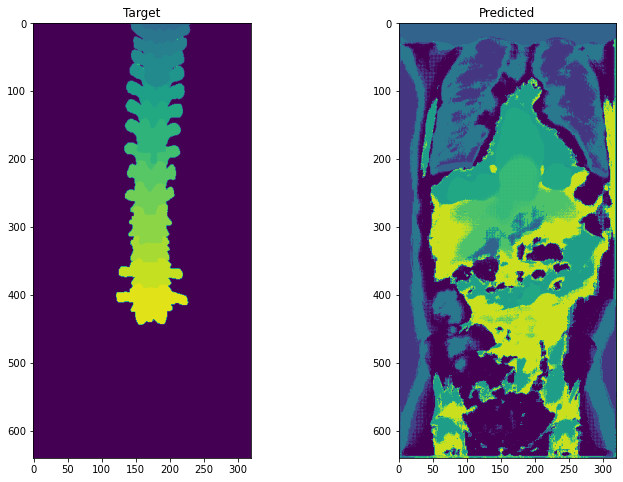

================================================== Training ==================================================
Epoch: 0, Train Loss: 0.9767854474705352, Average Dice Score: 0.04173280509793922
Dice Score Per Class
0: 0.18 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.18 9: 0.00 10: 0.05 11: 0.02 12: 0.00 13: 0.02 14: 0.05 15: 0.16 16: 0.11 17: 0.18 18: 0.03 19: 0.00 20: 0.00 21: 0.03 22: 0.02 23: 0.03 24: 0.00 25: 0.01
================================================= Validation =================================================
Epoch: 0, Val Loss: 0.9926563262939453, Average Dice Score: 0.004962433948679232
Dice Score Per Class
0: 0.18 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.18 9: 0.00 10: 0.05 11: 0.02 12: 0.00 13: 0.02 14: 0.05 15: 0.16 16: 0.11 17: 0.18 18: 0.03 19: 0.00 20: 0.00 21: 0.03 22: 0.02 23: 0.03 24: 0.00 25: 0.01


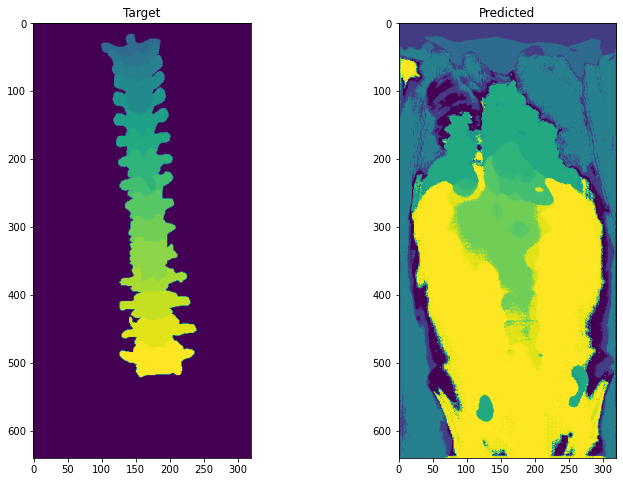

================================================== Training ==================================================
Epoch: 1, Train Loss: 0.9562157233791239, Average Dice Score: 0.08130557475900398
Dice Score Per Class
0: 0.30 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.30 9: 0.00 10: 0.05 11: 0.01 12: 0.01 13: 0.00 14: 0.17 15: 0.44 16: 0.14 17: 0.44 18: 0.16 19: 0.01 20: 0.00 21: 0.03 22: 0.03 23: 0.03 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 1, Val Loss: 0.9713053226470947, Average Dice Score: 0.02685328893960452
Dice Score Per Class
0: 0.30 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.30 9: 0.00 10: 0.05 11: 0.01 12: 0.01 13: 0.00 14: 0.17 15: 0.44 16: 0.14 17: 0.44 18: 0.16 19: 0.01 20: 0.00 21: 0.03 22: 0.03 23: 0.03 24: 0.00 25: 0.00


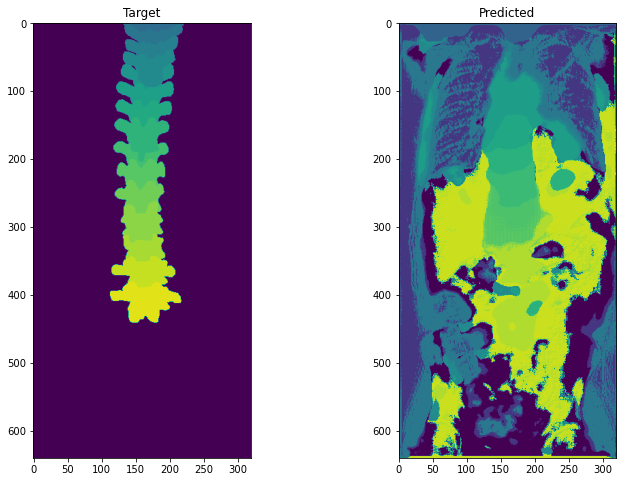

================================================== Training ==================================================
Epoch: 2, Train Loss: 0.9366580709903198, Average Dice Score: 0.11760110037312672
Dice Score Per Class
0: 0.21 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.36 9: 0.00 10: 0.05 11: 0.04 12: 0.09 13: 0.00 14: 0.27 15: 0.47 16: 0.39 17: 0.43 18: 0.37 19: 0.06 20: 0.00 21: 0.02 22: 0.27 23: 0.03 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 2, Val Loss: 0.964023745059967, Average Dice Score: 0.06200475472087409
Dice Score Per Class
0: 0.21 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.36 9: 0.00 10: 0.05 11: 0.04 12: 0.09 13: 0.00 14: 0.27 15: 0.47 16: 0.39 17: 0.43 18: 0.37 19: 0.06 20: 0.00 21: 0.02 22: 0.27 23: 0.03 24: 0.00 25: 0.00


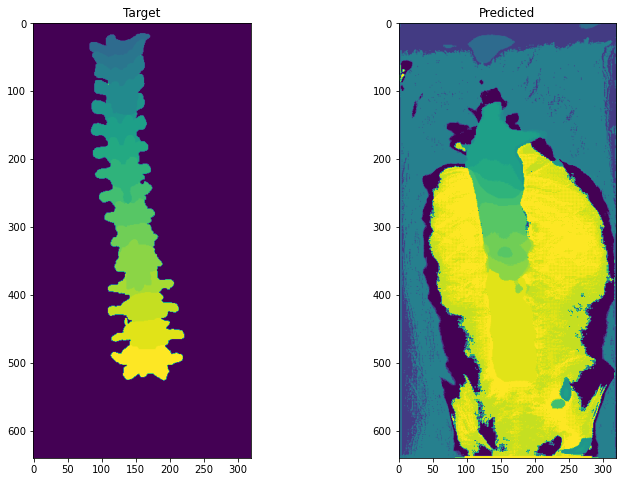

================================================== Training ==================================================
Epoch: 3, Train Loss: 0.9113822688717814, Average Dice Score: 0.16457565762507592
Dice Score Per Class
0: 0.28 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.48 9: 0.00 10: 0.04 11: 0.06 12: 0.10 13: 0.35 14: 0.35 15: 0.49 16: 0.47 17: 0.40 18: 0.42 19: 0.36 20: 0.03 21: 0.04 22: 0.38 23: 0.03 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 3, Val Loss: 0.983055031299591, Average Dice Score: 0.016889528532639152
Dice Score Per Class
0: 0.28 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.48 9: 0.00 10: 0.04 11: 0.06 12: 0.10 13: 0.35 14: 0.35 15: 0.49 16: 0.47 17: 0.40 18: 0.42 19: 0.36 20: 0.03 21: 0.04 22: 0.38 23: 0.03 24: 0.00 25: 0.00


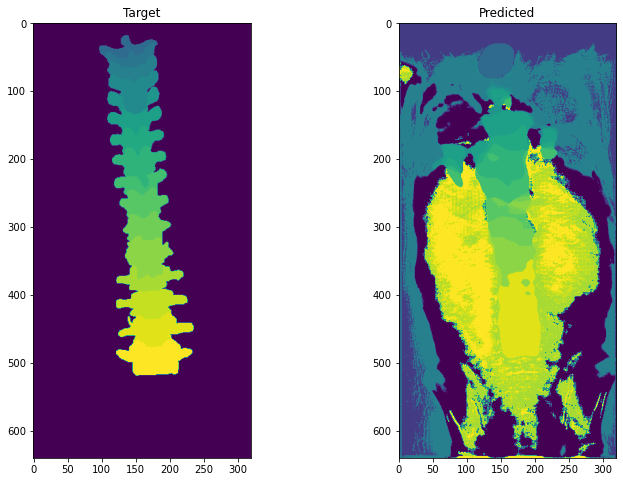

================================================== Training ==================================================
Epoch: 4, Train Loss: 0.8850046022403875, Average Dice Score: 0.18274665168175327
Dice Score Per Class
0: 0.33 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.53 9: 0.00 10: 0.05 11: 0.05 12: 0.07 13: 0.37 14: 0.41 15: 0.52 16: 0.51 17: 0.43 18: 0.48 19: 0.46 20: 0.05 21: 0.04 22: 0.43 23: 0.02 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 4, Val Loss: 0.9755305886268616, Average Dice Score: 0.020547948116451335
Dice Score Per Class
0: 0.33 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.53 9: 0.00 10: 0.05 11: 0.05 12: 0.07 13: 0.37 14: 0.41 15: 0.52 16: 0.51 17: 0.43 18: 0.48 19: 0.46 20: 0.05 21: 0.04 22: 0.43 23: 0.02 24: 0.00 25: 0.00


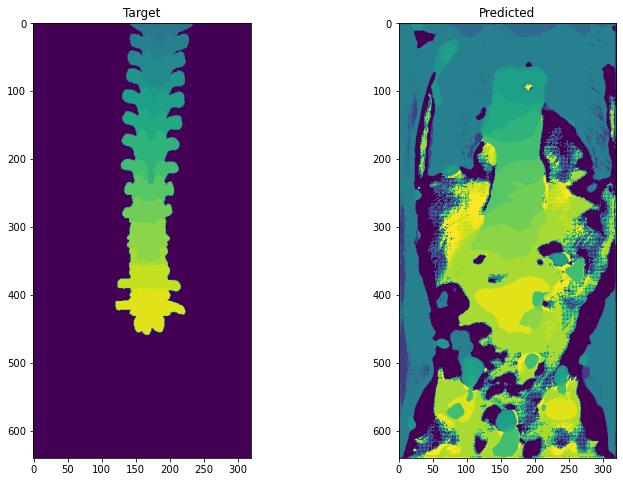

================================================== Training ==================================================
Epoch: 5, Train Loss: 0.8660816952321656, Average Dice Score: 0.19667708369699158
Dice Score Per Class
0: 0.37 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.57 9: 0.03 10: 0.05 11: 0.03 12: 0.15 13: 0.45 14: 0.47 15: 0.50 16: 0.48 17: 0.45 18: 0.50 19: 0.48 20: 0.08 21: 0.03 22: 0.45 23: 0.02 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 5, Val Loss: 0.9656441450119019, Average Dice Score: 0.05425254501382556
Dice Score Per Class
0: 0.37 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.57 9: 0.03 10: 0.05 11: 0.03 12: 0.15 13: 0.45 14: 0.47 15: 0.50 16: 0.48 17: 0.45 18: 0.50 19: 0.48 20: 0.08 21: 0.03 22: 0.45 23: 0.02 24: 0.00 25: 0.00


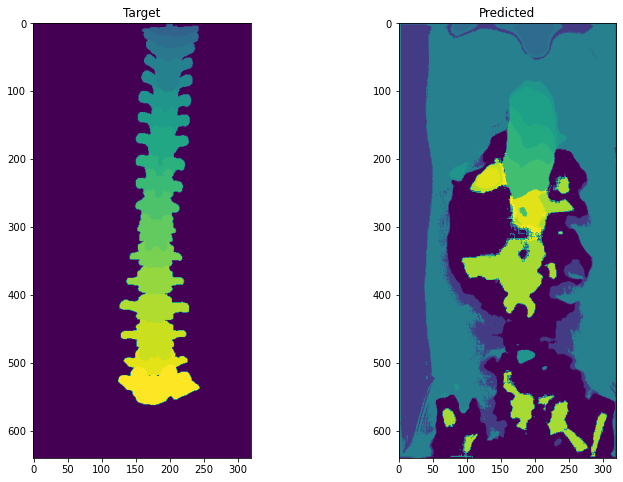

================================================== Training ==================================================
Epoch: 6, Train Loss: 0.8419388187002148, Average Dice Score: 0.21803284899422873
Dice Score Per Class
0: 0.46 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.53 9: 0.13 10: 0.05 11: 0.06 12: 0.26 13: 0.50 14: 0.52 15: 0.54 16: 0.57 17: 0.47 18: 0.51 19: 0.48 20: 0.11 21: 0.01 22: 0.48 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 6, Val Loss: 0.9803870320320129, Average Dice Score: 0.02421821783731056
Dice Score Per Class
0: 0.46 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.53 9: 0.13 10: 0.05 11: 0.06 12: 0.26 13: 0.50 14: 0.52 15: 0.54 16: 0.57 17: 0.47 18: 0.51 19: 0.48 20: 0.11 21: 0.01 22: 0.48 23: 0.00 24: 0.00 25: 0.00


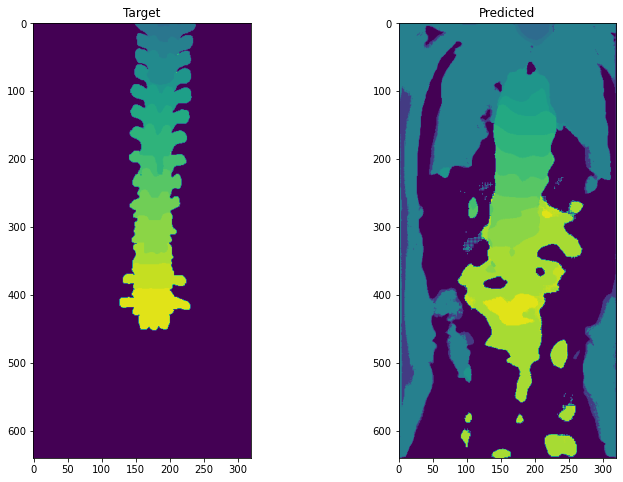

================================================== Training ==================================================
Epoch: 7, Train Loss: 0.8160078842964398, Average Dice Score: 0.24422502915562758
Dice Score Per Class
0: 0.56 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.65 9: 0.22 10: 0.04 11: 0.05 12: 0.39 13: 0.54 14: 0.52 15: 0.54 16: 0.56 17: 0.48 18: 0.51 19: 0.51 20: 0.24 21: 0.04 22: 0.50 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 7, Val Loss: 0.9784581422805786, Average Dice Score: 0.018598026313674364
Dice Score Per Class
0: 0.56 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.65 9: 0.22 10: 0.04 11: 0.05 12: 0.39 13: 0.54 14: 0.52 15: 0.54 16: 0.56 17: 0.48 18: 0.51 19: 0.51 20: 0.24 21: 0.04 22: 0.50 23: 0.00 24: 0.00 25: 0.00


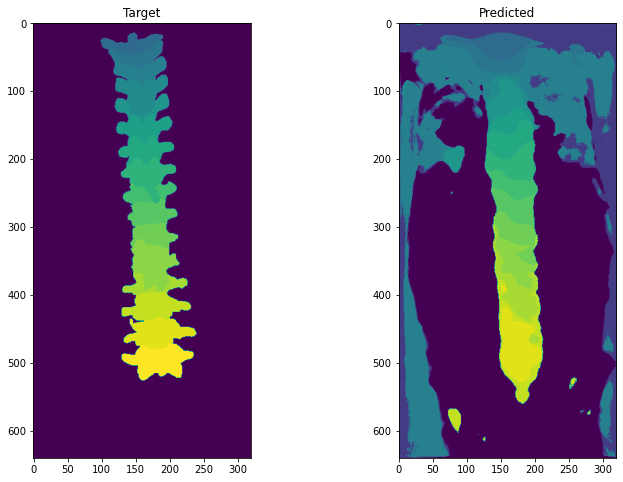

================================================== Training ==================================================
Epoch: 8, Train Loss: 0.787222282420954, Average Dice Score: 0.27402241677018785
Dice Score Per Class
0: 0.62 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.72 9: 0.44 10: 0.04 11: 0.10 12: 0.42 13: 0.52 14: 0.53 15: 0.55 16: 0.58 17: 0.53 18: 0.53 19: 0.48 20: 0.40 21: 0.16 22: 0.50 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 8, Val Loss: 0.9325632691383362, Average Dice Score: 0.09563036520173594
Dice Score Per Class
0: 0.62 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.72 9: 0.44 10: 0.04 11: 0.10 12: 0.42 13: 0.52 14: 0.53 15: 0.55 16: 0.58 17: 0.53 18: 0.53 19: 0.48 20: 0.40 21: 0.16 22: 0.50 23: 0.00 24: 0.00 25: 0.00


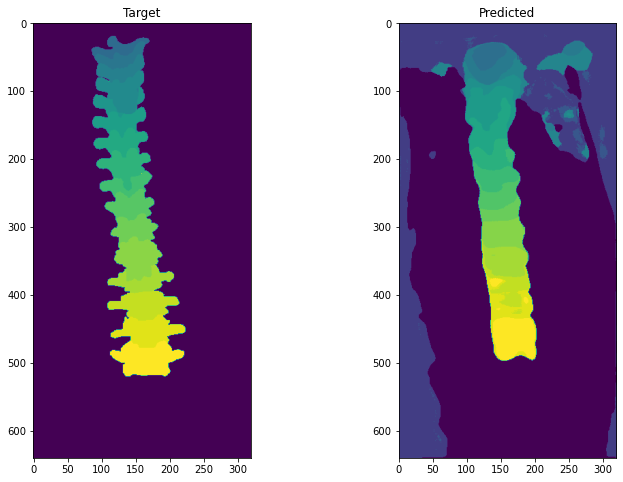

================================================== Training ==================================================
Epoch: 9, Train Loss: 0.740519351507785, Average Dice Score: 0.32474589156138345
Dice Score Per Class
0: 0.66 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.74 9: 0.59 10: 0.15 11: 0.32 12: 0.56 13: 0.63 14: 0.61 15: 0.59 16: 0.63 17: 0.61 18: 0.55 19: 0.53 20: 0.38 21: 0.33 22: 0.56 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 9, Val Loss: 0.9453596472740173, Average Dice Score: 0.07396108172508827
Dice Score Per Class
0: 0.66 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.74 9: 0.59 10: 0.15 11: 0.32 12: 0.56 13: 0.63 14: 0.61 15: 0.59 16: 0.63 17: 0.61 18: 0.55 19: 0.53 20: 0.38 21: 0.33 22: 0.56 23: 0.00 24: 0.00 25: 0.00


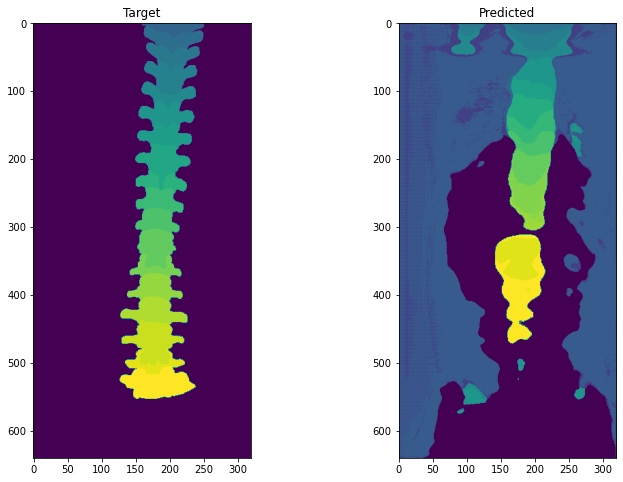

================================================== Training ==================================================
Epoch: 10, Train Loss: 0.7055463572225628, Average Dice Score: 0.347921996617271
Dice Score Per Class
0: 0.69 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.73 9: 0.62 10: 0.30 11: 0.51 12: 0.56 13: 0.62 14: 0.58 15: 0.59 16: 0.63 17: 0.63 18: 0.55 19: 0.52 20: 0.50 21: 0.44 22: 0.59 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 10, Val Loss: 0.843567156791687, Average Dice Score: 0.19390018840196646
Dice Score Per Class
0: 0.69 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.73 9: 0.62 10: 0.30 11: 0.51 12: 0.56 13: 0.62 14: 0.58 15: 0.59 16: 0.63 17: 0.63 18: 0.55 19: 0.52 20: 0.50 21: 0.44 22: 0.59 23: 0.00 24: 0.00 25: 0.00


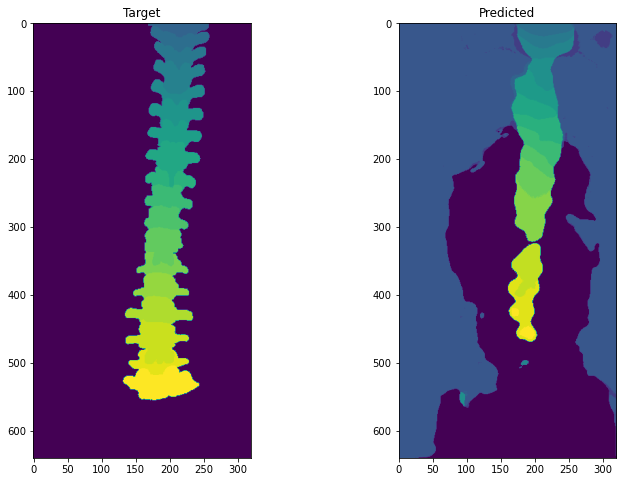

================================================== Training ==================================================
Epoch: 11, Train Loss: 0.6605981306211482, Average Dice Score: 0.38148815348472154
Dice Score Per Class
0: 0.72 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.74 9: 0.63 10: 0.46 11: 0.59 12: 0.60 13: 0.64 14: 0.64 15: 0.63 16: 0.64 17: 0.64 18: 0.65 19: 0.57 20: 0.61 21: 0.52 22: 0.61 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 11, Val Loss: 0.9453277111053466, Average Dice Score: 0.05994461733303234
Dice Score Per Class
0: 0.72 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.74 9: 0.63 10: 0.46 11: 0.59 12: 0.60 13: 0.64 14: 0.64 15: 0.63 16: 0.64 17: 0.64 18: 0.65 19: 0.57 20: 0.61 21: 0.52 22: 0.61 23: 0.00 24: 0.00 25: 0.00


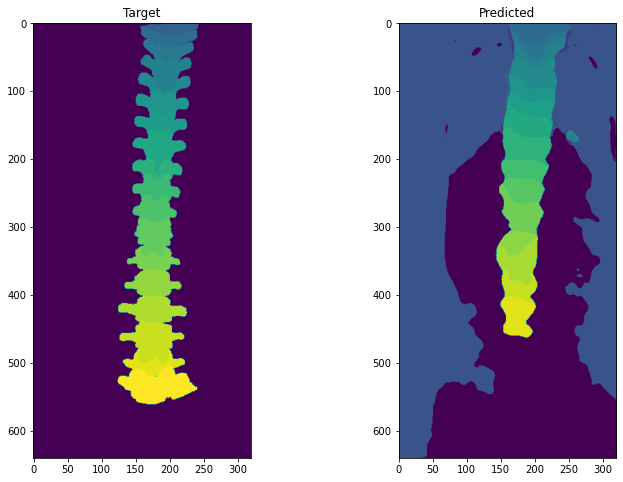

================================================== Training ==================================================
Epoch: 12, Train Loss: 0.6345210152970263, Average Dice Score: 0.39334026065140176
Dice Score Per Class
0: 0.75 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.72 9: 0.61 10: 0.52 11: 0.62 12: 0.64 13: 0.65 14: 0.65 15: 0.64 16: 0.65 17: 0.69 18: 0.71 19: 0.58 20: 0.58 21: 0.56 22: 0.67 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 12, Val Loss: 0.925698459148407, Average Dice Score: 0.08042312776891294
Dice Score Per Class
0: 0.75 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.72 9: 0.61 10: 0.52 11: 0.62 12: 0.64 13: 0.65 14: 0.65 15: 0.64 16: 0.65 17: 0.69 18: 0.71 19: 0.58 20: 0.58 21: 0.56 22: 0.67 23: 0.00 24: 0.00 25: 0.00


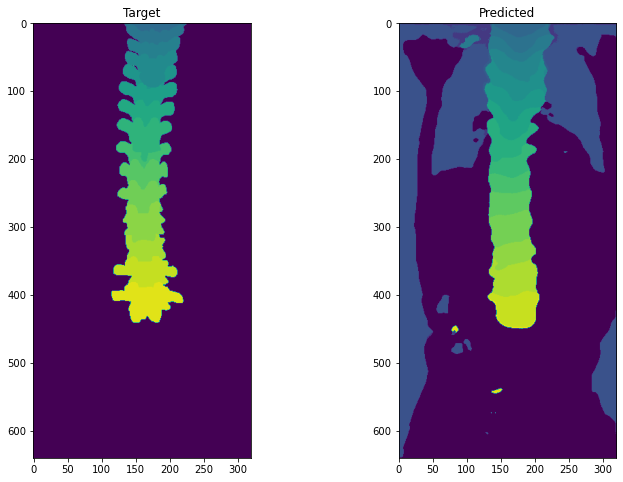

================================================== Training ==================================================
Epoch: 13, Train Loss: 0.6055726803971465, Average Dice Score: 0.4153152193252147
Dice Score Per Class
0: 0.76 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.74 9: 0.65 10: 0.62 11: 0.65 12: 0.65 13: 0.66 14: 0.65 15: 0.64 16: 0.66 17: 0.70 18: 0.72 19: 0.66 20: 0.62 21: 0.62 22: 0.73 23: 0.07 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 13, Val Loss: 0.9358912467956543, Average Dice Score: 0.08938474258873519
Dice Score Per Class
0: 0.76 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.74 9: 0.65 10: 0.62 11: 0.65 12: 0.65 13: 0.66 14: 0.65 15: 0.64 16: 0.66 17: 0.70 18: 0.72 19: 0.66 20: 0.62 21: 0.62 22: 0.73 23: 0.07 24: 0.00 25: 0.00


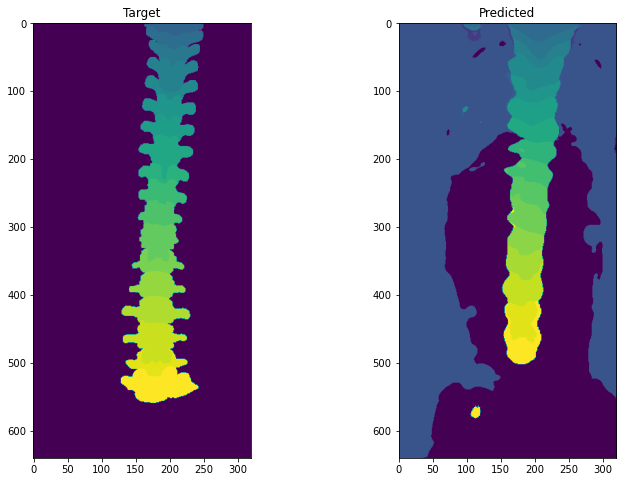

================================================== Training ==================================================
Epoch: 14, Train Loss: 0.5918500659733834, Average Dice Score: 0.43024162476321326
Dice Score Per Class
0: 0.78 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.73 9: 0.65 10: 0.62 11: 0.65 12: 0.64 13: 0.67 14: 0.68 15: 0.66 16: 0.68 17: 0.73 18: 0.73 19: 0.69 20: 0.63 21: 0.64 22: 0.71 23: 0.31 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 14, Val Loss: 0.8453160405158997, Average Dice Score: 0.16514345635230274
Dice Score Per Class
0: 0.78 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.73 9: 0.65 10: 0.62 11: 0.65 12: 0.64 13: 0.67 14: 0.68 15: 0.66 16: 0.68 17: 0.73 18: 0.73 19: 0.69 20: 0.63 21: 0.64 22: 0.71 23: 0.31 24: 0.00 25: 0.00


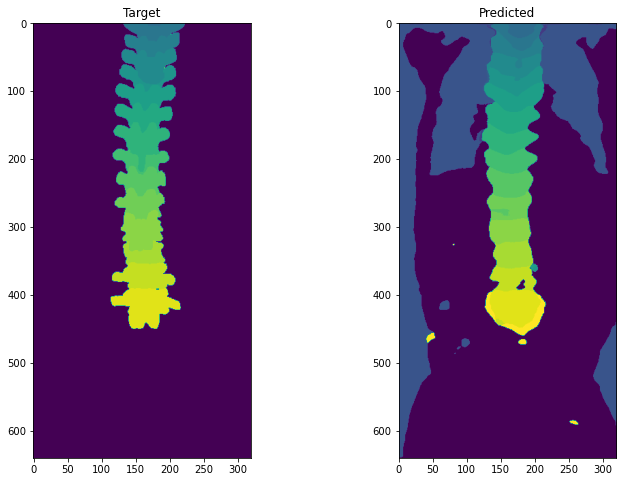

================================================== Training ==================================================
Epoch: 15, Train Loss: 0.5679907692960028, Average Dice Score: 0.450350859169727
Dice Score Per Class
0: 0.78 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.75 9: 0.68 10: 0.65 11: 0.68 12: 0.69 13: 0.70 14: 0.70 15: 0.70 16: 0.72 17: 0.73 18: 0.75 19: 0.72 20: 0.65 21: 0.65 22: 0.72 23: 0.44 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 15, Val Loss: 0.9298113465309144, Average Dice Score: 0.07813126807061505
Dice Score Per Class
0: 0.78 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.75 9: 0.68 10: 0.65 11: 0.68 12: 0.69 13: 0.70 14: 0.70 15: 0.70 16: 0.72 17: 0.73 18: 0.75 19: 0.72 20: 0.65 21: 0.65 22: 0.72 23: 0.44 24: 0.00 25: 0.00


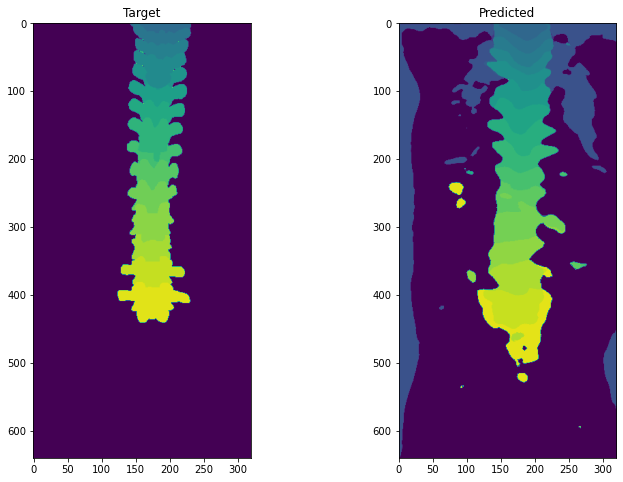

================================================== Training ==================================================
Epoch: 16, Train Loss: 0.5625207487648055, Average Dice Score: 0.45318046863390155
Dice Score Per Class
0: 0.80 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.74 9: 0.67 10: 0.67 11: 0.69 12: 0.70 13: 0.69 14: 0.70 15: 0.69 16: 0.71 17: 0.73 18: 0.75 19: 0.71 20: 0.67 21: 0.67 22: 0.72 23: 0.48 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 16, Val Loss: 0.8444581031799316, Average Dice Score: 0.16452330356610934
Dice Score Per Class
0: 0.80 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.74 9: 0.67 10: 0.67 11: 0.69 12: 0.70 13: 0.69 14: 0.70 15: 0.69 16: 0.71 17: 0.73 18: 0.75 19: 0.71 20: 0.67 21: 0.67 22: 0.72 23: 0.48 24: 0.00 25: 0.00


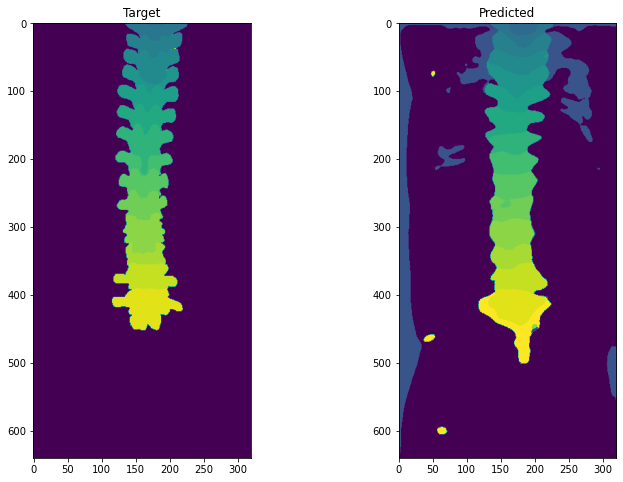

================================================== Training ==================================================
Epoch: 17, Train Loss: 0.5509381445907277, Average Dice Score: 0.4632352293926716
Dice Score Per Class
0: 0.82 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.75 9: 0.70 10: 0.68 11: 0.70 12: 0.71 13: 0.71 14: 0.72 15: 0.69 16: 0.69 17: 0.72 18: 0.75 19: 0.73 20: 0.69 21: 0.68 22: 0.75 23: 0.55 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 17, Val Loss: 0.8013466835021973, Average Dice Score: 0.2035532698890235
Dice Score Per Class
0: 0.82 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.75 9: 0.70 10: 0.68 11: 0.70 12: 0.71 13: 0.71 14: 0.72 15: 0.69 16: 0.69 17: 0.72 18: 0.75 19: 0.73 20: 0.69 21: 0.68 22: 0.75 23: 0.55 24: 0.00 25: 0.00


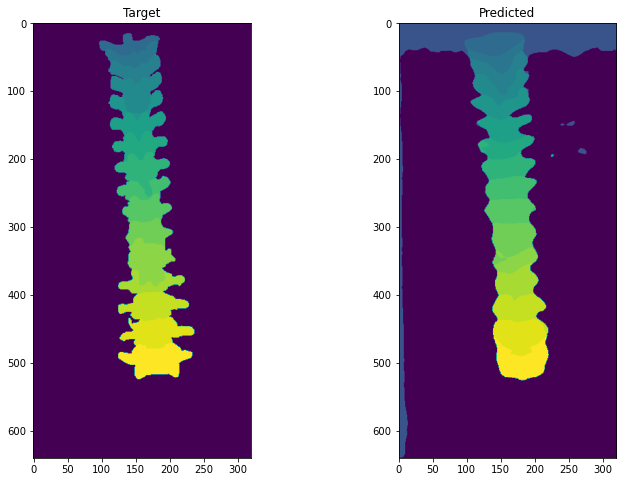

================================================== Training ==================================================
Epoch: 18, Train Loss: 0.5430235093867285, Average Dice Score: 0.4701681288903501
Dice Score Per Class
0: 0.83 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.76 9: 0.72 10: 0.69 11: 0.72 12: 0.72 13: 0.71 14: 0.71 15: 0.70 16: 0.72 17: 0.74 18: 0.76 19: 0.72 20: 0.72 21: 0.69 22: 0.73 23: 0.58 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 18, Val Loss: 0.9090973973274231, Average Dice Score: 0.11038950909672302
Dice Score Per Class
0: 0.83 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.76 9: 0.72 10: 0.69 11: 0.72 12: 0.72 13: 0.71 14: 0.71 15: 0.70 16: 0.72 17: 0.74 18: 0.76 19: 0.72 20: 0.72 21: 0.69 22: 0.73 23: 0.58 24: 0.00 25: 0.00


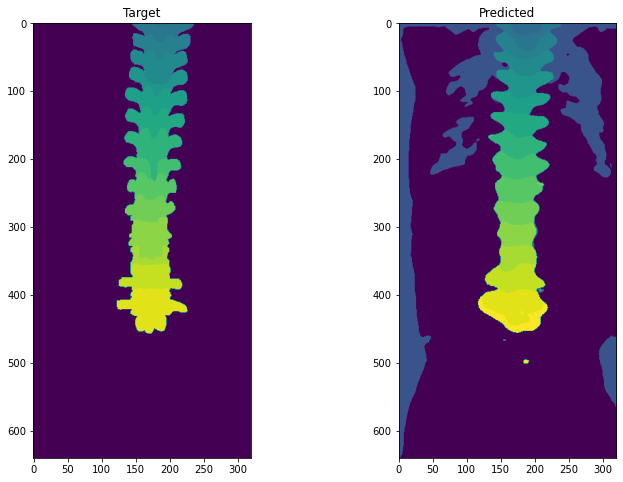

================================================== Training ==================================================
Epoch: 19, Train Loss: 0.5272363459570168, Average Dice Score: 0.48531919786165617
Dice Score Per Class
0: 0.85 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.77 9: 0.71 10: 0.72 11: 0.72 12: 0.73 13: 0.72 14: 0.74 15: 0.74 16: 0.74 17: 0.77 18: 0.78 19: 0.76 20: 0.74 21: 0.72 22: 0.78 23: 0.63 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 19, Val Loss: 0.6437764286994934, Average Dice Score: 0.3765780609803213
Dice Score Per Class
0: 0.85 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.77 9: 0.71 10: 0.72 11: 0.72 12: 0.73 13: 0.72 14: 0.74 15: 0.74 16: 0.74 17: 0.77 18: 0.78 19: 0.76 20: 0.74 21: 0.72 22: 0.78 23: 0.63 24: 0.00 25: 0.00


In [8]:
# Initialize 
displayBatch =  False
displayEpoch =  True
epoch_train_loss = []
epoch_train_accuracy_per_class = []
epoch_train_accuracy_average = []

epoch_val_loss = []
epoch_val_accuracy_per_class = []
epoch_val_accuracy_average = []

for epic in range(num_epochs):
    
    # Put model in training mode
    model.train()
    
    train_total = 0
    train_batch_loss = 0
    train_batch_accuracy = np.empty((0, num_classes))
    
    for i, sample in enumerate(train_dataloader):
        
        # move inputs to device
        if torch.cuda.is_available():
            x = sample['img'].to(device)
            y = sample['mask'].to(device)
        
        # Loop over model, calculate loss
        optimizer.zero_grad()
        output = model.forward(x)  # N K H W
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        # Dice score for training
        train_batch_accuracy = np.vstack((train_batch_accuracy, dice_score(output, y)))
        
        # Display
        if displayBatch is True:
            _, y_hat = torch.max(output, dim=1) # argmax over classes
            _, y_flat = torch.max(y.detach().clone(), dim=1)
            disp_mask = y_flat.cpu().numpy()
            disp_y_hat = y_hat.cpu().numpy()
            plt.figure(figsize=(12,8))
            plt.subplot(1,2,1)
            plt.imshow(disp_mask[0])
            plt.title("Target")
            plt.subplot(1,2,2)
            plt.imshow(disp_y_hat[0])
            plt.title("Predicted")
            plt.show()
        
        # Since loss is averaged over class and batch, to get total loss we need to multiply by NK
        N, K, H, W = x.shape
        train_total += N*K
        train_batch_loss += loss.item() * N * K

    if displayEpoch is True:
        _, y_hat = torch.max(output, dim=1) # argmax over classes
        _, y_flat = torch.max(y.detach().clone(), dim=1)
        disp_mask = y_flat.cpu().numpy()
        disp_y_hat = y_hat.cpu().numpy()
        plt.figure(figsize=(12,8))
        plt.subplot(1,2,1)
        plt.imshow(disp_mask[0])
        plt.title("Target")
        plt.subplot(1,2,2)
        plt.imshow(disp_y_hat[0])
        plt.title("Predicted")
        plt.show()
        
    # Append to epoch loss/accuracy
    epoch_train_loss.append(train_batch_loss / train_total)
    a = train_batch_accuracy.mean(axis=0)
    epoch_train_accuracy_per_class.append(a) # mean over class to get per class accuracy
    epoch_train_accuracy_average.append(train_batch_accuracy.mean())
    
    print('='*50 + " Training " + '='*50)
    print(f'Epoch: {epic}, Train Loss: {epoch_train_loss[-1]}, Average Dice Score: {epoch_train_accuracy_average[-1]}')
    print('Dice Score Per Class')
    print('0: {0:.2f} 1: {1:.2f} 2: {2:.2f} 3: {3:.2f} 4: {4:.2f} 5: {5:.2f} 6: {6:.2f} 7: {7:.2f} 8: {8:.2f} 9: {9:.2f} 10: {10:.2f} 11: {11:.2f} 12: {12:.2f} 13: {13:.2f} 14: {14:.2f} 15: {15:.2f} 16: {16:.2f} 17: {17:.2f} 18: {18:.2f} 19: {19:.2f} 20: {20:.2f} 21: {21:.2f} 22: {22:.2f} 23: {23:.2f} 24: {24:.2f} 25: {25:.2f}'.format(a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9], a[10], a[11], a[12], a[13], a[14], a[15], a[16], a[17], a[18], a[19], a[20], a[21], a[22], a[23], a[24], a[25]))
    
    # Put model in validation mode
    model.eval()

    val_total = 0
    val_batch_loss = 0
    val_batch_accuracy = np.empty((0, num_classes))
          
    with torch.no_grad():
        for i, sample in enumerate(val_dataloader):
            
            # move inputs to device
            if torch.cuda.is_available():
                x = sample['img'].to(device)
                y = sample['mask'].to(device)
            
            output = model.forward(x)
            loss = loss_fn(output, y)
            
            # Dice score for training
            val_batch_accuracy = np.vstack((val_batch_accuracy, dice_score(output, y)))
            
            # Since loss is averaged over class and batch, to get total loss we need to multiply by NK
            N, K, H, W = x.shape
            val_total += N*K
            val_batch_loss += loss.item() * N * K
            
        # Append to epoch loss/accuracy
        epoch_val_loss.append(val_batch_loss / val_total)
        b = val_batch_accuracy.mean(axis=0)
        epoch_val_accuracy_per_class.append(a) # mean over class to get per class accuracy
        epoch_val_accuracy_average.append(val_batch_accuracy.mean())
        
        print('='*49 + " Validation " + '='*49)
        print(f'Epoch: {epic}, Val Loss: {epoch_val_loss[-1]}, Average Dice Score: {epoch_val_accuracy_average[-1]}')
        print('Dice Score Per Class')
        print('0: {0:.2f} 1: {1:.2f} 2: {2:.2f} 3: {3:.2f} 4: {4:.2f} 5: {5:.2f} 6: {6:.2f} 7: {7:.2f} 8: {8:.2f} 9: {9:.2f} 10: {10:.2f} 11: {11:.2f} 12: {12:.2f} 13: {13:.2f} 14: {14:.2f} 15: {15:.2f} 16: {16:.2f} 17: {17:.2f} 18: {18:.2f} 19: {19:.2f} 20: {20:.2f} 21: {21:.2f} 22: {22:.2f} 23: {23:.2f} 24: {24:.2f} 25: {25:.2f}'.format(a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9], a[10], a[11], a[12], a[13], a[14], a[15], a[16], a[17], a[18], a[19], a[20], a[21], a[22], a[23], a[24], a[25]))
        print('='*110)

In [9]:
torch.save(model.state_dict(), 'saved_models/debug')

In [10]:
# Save stats and what not
import pickle

debug_stats = {'epoch_train_loss': epoch_train_loss,
             'epoch_train_accuracy_per_class': epoch_train_accuracy_per_class,
             'epoch_train_accuracy_average': epoch_train_accuracy_average,
             'epoch_val_loss': epoch_val_loss,
             'epoch_val_accuracy_per_class': epoch_val_accuracy_per_class,
             'epoch_val_accuracy_average': epoch_val_accuracy_average
            }

In [11]:
with open('debug_stats.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

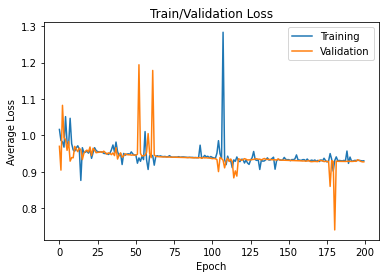

In [12]:
plt.figure()
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training", "Validation"])

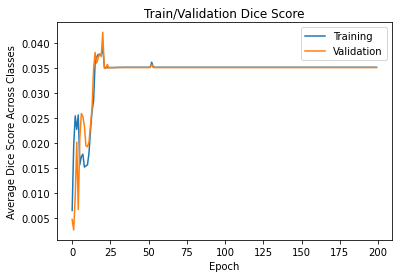

In [13]:
plt.figure()
plt.plot(epoch_train_accuracy_average)
plt.plot(epoch_val_accuracy_average)
plt.xlabel("Epoch")
plt.ylabel("Average Dice Score Across Classes")
plt.title("Train/Validation Dice Score")
plt.legend(["Training", "Validation"])

In [8]:
## Uncomment to load in model
num_classes = 26
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = unet(num_classes=num_classes, useBN=True)
model.load_state_dict(torch.load('saved_models/r1'))
model.to(device)
model.eval()

Tesla K80


unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

Testing sample: 0
Displaying stats for case 0:
output shape is torch.Size([1, 26, 640, 320])
Displaying mask stats for case 0:


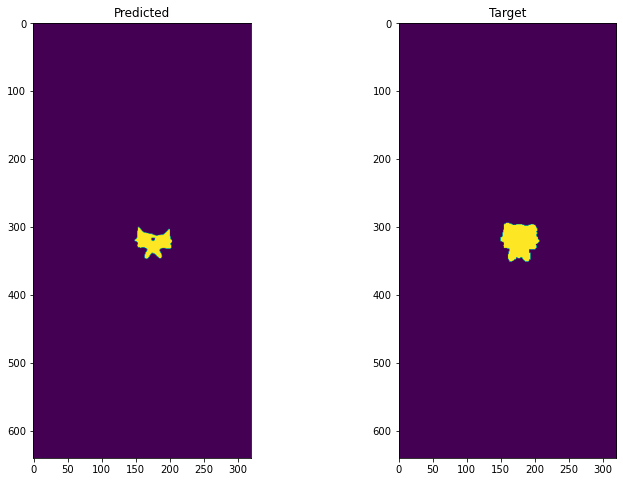

In [9]:
# Evaluate Model on Test Data

# Put in eval mode
model.eval()

test_total = 0
test_batch_loss = 0
test_batch_accuracy = np.empty((0, num_classes))

with torch.no_grad():
    for i, sample in enumerate(test_dataloader):
        if i != 0:
            continue
        print('Testing sample:',i)
        
#         _, y_hat = torch.max(output, dim=1) # argmax over classes
#         _, y_flat = torch.max(y.detach().clone(), dim=1)
#         disp_mask = y_flat.cpu().numpy()
#         disp_y_hat = y_hat.cpu().numpy()
#         plt.figure(figsize=(12,8))
#         plt.subplot(1,2,1)
#         plt.imshow(disp_mask[0])
#         plt.title("Target")
#         plt.subplot(1,2,2)
#         plt.imshow(disp_y_hat[0])
#         plt.title("Predicted")
#         plt.show()

        # move inputs to device
        if torch.cuda.is_available():
            x = sample['img'].to(device)
            y = sample['mask'].to(device)
        
            output = model.forward(x)
            
        output_data = output.clone().detach().cpu()
        output_uniques = np.unique(output_data)
#         print('unique values of output are:',output_uniques)
#         for value in output_uniques:
#             if value > 0.5:
#                 print(value)
            
        print('Displaying stats for case 0:')
        print('output shape is',np.shape(output))  # [1, 26, 640, 320]
        output_plt = output_data

        print('Displaying mask stats for case 0:')            
        plt.figure(figsize=(12,8))
        plt.subplot(1,2,1)
        plt.imshow(output_plt[0,19,:,:])
        plt.title('Predicted')
        plt.subplot(1,2,2)
        plt.imshow(sample['mask'][0,19,:,:])
        plt.title('Target')
        plt.show()

        # Dice score for training
#         test_batch_accuracy = np.vstack((val_batch_accuracy, dice_score(output, y)))

### slice 19 examination

In [22]:
# before that: look at some pixels and see if all values across classes add to 1

output_data[0,19,325,200]  # should be in mid of vertebra
sum_325_200 = 0
for idx in range(np.shape(output_data)[1]):  # 26
    sum_325_200 += output_data[0,idx,325,200]
    
print(sum_325_200)

output_data[0,19,325,175]  # should be in mid of vertebra
sum_325_175 = 0
for idx in range(np.shape(output_data)[1]):  # 26, num of vertebrae
    sum_325_175 += output_data[0,idx,325,175]
    
print(sum_325_175)

0.9999999171812051
0.9999999249999608


In [13]:
output_data = output_data.numpy()
print(np.shape(output_data))

(1, 26, 640, 320)


In [15]:
np.shape(np.unique(output_data[0,19,:,:]))

(203571,)

In [16]:
np.unique(output_data[0,19,:,:])

array([4.8800922e-28, 3.8394584e-26, 4.2784571e-26, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

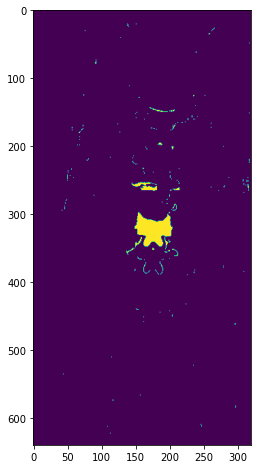

In [10]:
slice19 = output_data[0,19,:,:]
threshed19 = np.zeros((640,320))

for i in range(640):
    for j in range(320):
        if slice19[i,j] > 0.00001:
            threshed19[i,j] = 1
            
plt.figure(figsize=(12,8))
plt.imshow(threshed19)

In [11]:
half_sures = []
for i in range(640):
    for j in range(320):
        if slice19[i,j] > 0.5 and slice19[i,j] < 0.6:
            half_sures.append(slice19[i,j])
            
print(np.shape(half_sures))

(7,)


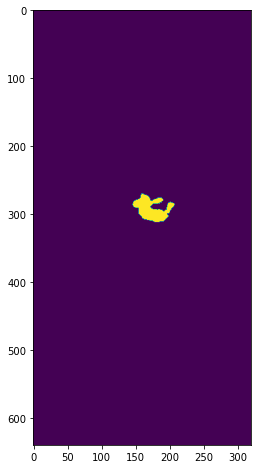

In [28]:
slice18 = output_data[0,18,:,:]
threshed18 = np.zeros((640,320))

for i in range(640):
    for j in range(320):
        if slice18[i,j] > 0.9:
            threshed18[i,j] = 1
            
plt.figure(figsize=(12,8))
plt.imshow(threshed18)

### debug

In [33]:
print(type(train_dataset))

<class '__main__.SegmentationDataset'>


In [59]:
trackdata = {}
for i, sample in enumerate(train_dataloader):
    trackdata[i] = sample

In [60]:
train_dataloader.__len__()

30

In [61]:
len(trackdata)

30

In [62]:
data0 = trackdata[0]
img0 = data0['img'].numpy()
mask0 = data0['mask'].numpy()

In [63]:
print(np.shape(img0),np.shape(mask0))

(10, 3, 256, 320) (10, 8, 256, 320)


In [30]:
trackpath = r'HW6_data/segmentation/train/0'
trackimg = os.path.join(trackpath, '0_input.jpg')
track = io.imread(trackimg)

print(np.shape(track))

(256, 320, 3)


In [68]:
track_dir = os.path.join(input_data_dir, 'train')
next(os.walk(track_dir))[2]

['Icon', '.DS_Store']